In [1]:
import os
os.environ['R_HOME'] = '/usr/lib/R'
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from anndata import AnnData
import scanpy as sc


In [2]:
adata=sc.read("adata_fpm.h5ad")
adata.obsm['X_ms_data_gene']=pd.read_csv('ms_data_gene.csv',index_col=0).values

In [3]:
import scvelo as scv
sc.set_figure_params(figsize=(5,5),dpi_save=600)

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']

In [4]:
annot_plates=pd.read_table("plates_locations.tab",index_col=0)
adata.obs["plates"]=list(map(lambda x: x.split(":")[0],adata.obs_names))
adata.obs["locations"]=adata.obs["plates"]
for cat in adata.obs["plates"].unique():
    adata.obs.loc[adata.obs["plates"]==cat,"locations"]=annot_plates.loc[cat,"Location - annotation"]
adata.obs["plates"]=adata.obs["plates"].astype("category")
adata.obs["locations"]=adata.obs["locations"].astype("category")

In [5]:
adata.obsm["X_umap2"]=adata.obsm["X_umap"]

In [6]:
adata.obsm["X_umap"]=pd.read_csv("UMAP_Glia_mega.csv",index_col=0).values

In [7]:
adata.obs["leiden"]=pd.read_csv("leiden.csv")["x"].values.astype(str)

... storing 'leiden' as categorical


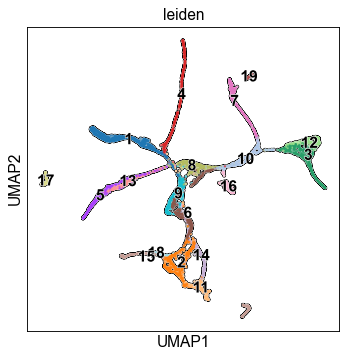

In [8]:
sc.pl.umap(adata,color="leiden",legend_loc='on data',add_outline=True,legend_fontoutline=True)

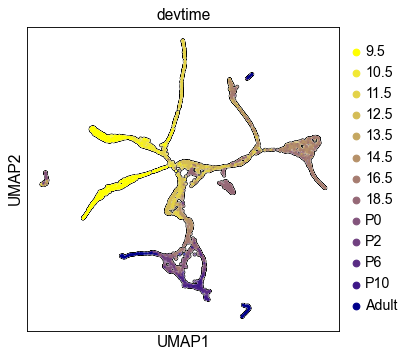

In [9]:
sc.pl.umap(adata,color="devtime",add_outline=True,legend_fontoutline=True)

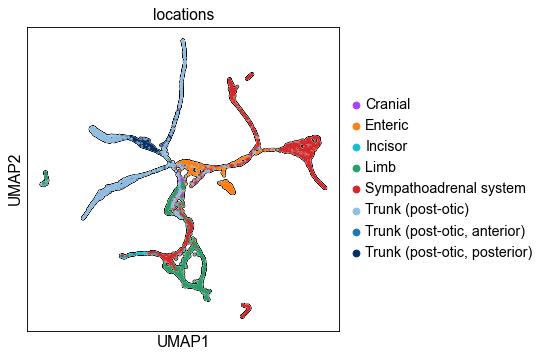

In [10]:
sc.pl.umap(adata,color="locations",add_outline=True,legend_fontoutline=True)

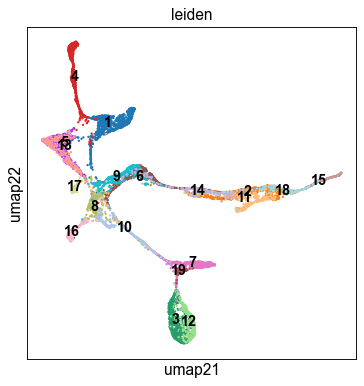

In [11]:
sc.pl.scatter(adata,basis="umap2",color="leiden",legend_loc='on data')

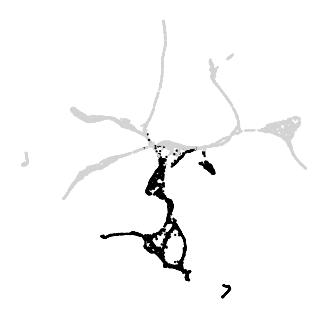

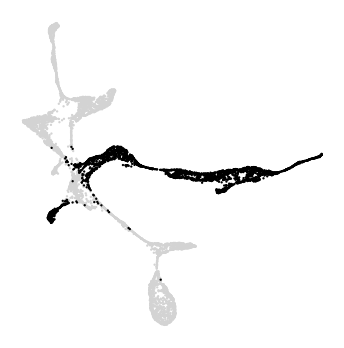

In [12]:

adata.obs["sel"]=adata.obs.leiden.isin(["16","9","6","14","11","2","15","18"])
adata.obs["sel"]=adata.obs["sel"].astype("category")
sc.pl.umap(adata,color="sel",palette=["lightgrey","black"],frameon=False,legend_loc="none",title="",
           save="-Glial_hetero.png")

sc.pl.scatter(adata,basis="umap2",color="sel",palette=["lightgrey","black"],frameon=False,legend_loc="none",title="",
           save="-Glial_hetero_auc.png")

In [13]:
adata_glia=adata[adata.obs.leiden.isin(["16","9","6","14","11","2","15","18"])]

sc.pp.pca(adata_glia)

In [14]:
sc.pp.neighbors(adata_glia,n_neighbors=30,use_rep='X_ms_data_gene')

In [15]:
adata_glia.obs.leiden=adata_glia.obs.leiden.cat.reorder_categories(['9','6','14','2','11','18','15','16'])
adata_glia.obs.leiden=adata_glia.obs.leiden.cat.rename_categories(['Migratory SCP 1','Migratory SCP 2','pro mSC-enFib','mSC','enFib','nmSC 1','nmSC 2','Gut glia'])

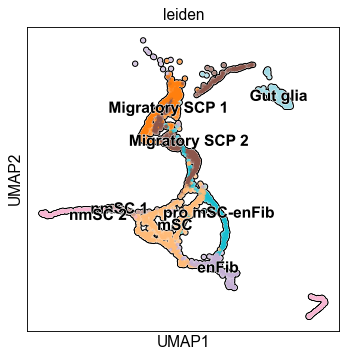

In [16]:
sc.pl.umap(adata_glia,color="leiden",legend_loc='on data',add_outline=True,legend_fontoutline=True,
          save="Glial_Hetero_leiden.png")

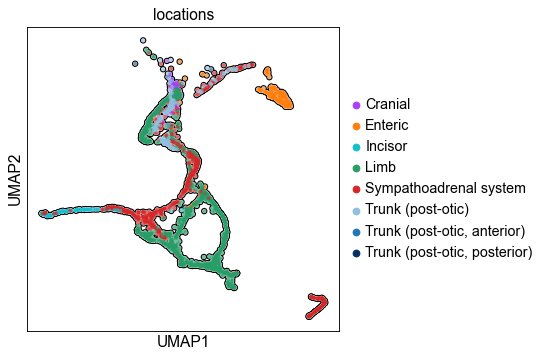

In [17]:
sc.pl.umap(adata_glia,color="locations",add_outline=True,legend_fontoutline=True,
          save="Glial_Hetero_locations.png")

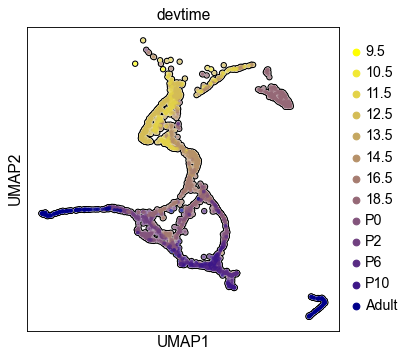

In [18]:
sc.pl.umap(adata_glia,color="devtime",add_outline=True,legend_fontoutline=True,
          save="Glial_Hetero_devtime.png")

In [19]:
sc.tl.rank_genes_groups(adata_glia,"leiden",method="wilcoxon")

In [20]:
adata_glia.layers["scaled"]=sc.pp.scale(adata_glia.X,copy=True)

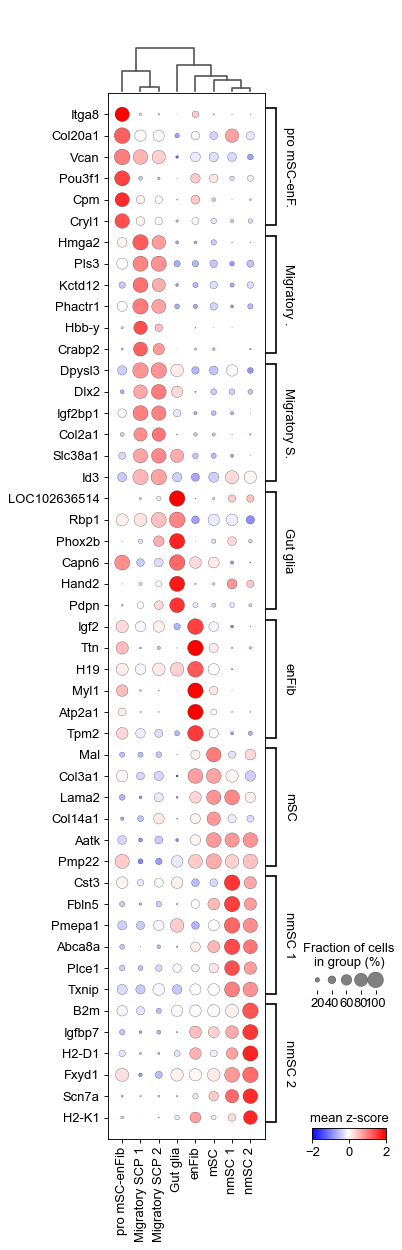

In [21]:
sc.pl.rank_genes_groups_dotplot(adata_glia,layer="scaled",cmap="bwr",
                                vmin=-2,vmax=2,swap_axes=True,
                                min_logfoldchange=1.5,n_genes=6,
                               save="Glial_heterogeneity_6.svg",
                                colorbar_title='mean z-score')

In [22]:
adata_glia.obs.locations.value_counts()

Limb                            1168
Sympathoadrenal system           795
Enteric                          277
Trunk (post-otic)                168
Incisor                          130
Cranial                           75
Trunk (post-otic, anterior)       10
Trunk (post-otic, posterior)       1
Name: locations, dtype: int64

In [23]:
rem=~(adata_glia.obs.locations.isin(["Trunk (post-otic, posterior)","Trunk (post-otic, anterior)"]) | adata_glia.obs.devtime.isin(["9.5"]))

In [24]:
adata_glia.obs.locations=adata_glia.obs.locations.cat.reorder_categories(['Cranial',
       'Trunk (post-otic)', 'Trunk (post-otic, anterior)',
       'Trunk (post-otic, posterior)', 'Limb','Enteric', 'Sympathoadrenal system','Incisor'])

In [25]:
adata_glia.obs["devloc"]=adata.obs.locations.astype(str) + " " + adata.obs.devtime.astype(str) 

In [26]:
adata_glia.obs.devloc=adata_glia.obs.devloc.astype("category")

In [27]:
adata_glia.obs.devloc.cat.categories

Index(['Cranial 12.5', 'Enteric 12.5', 'Enteric 18.5', 'Incisor Adult',
       'Limb 12.5', 'Limb 14.5', 'Limb 16.5', 'Limb 18.5', 'Limb P0',
       'Limb P10', 'Limb P6', 'Sympathoadrenal system 12.5',
       'Sympathoadrenal system 13.5', 'Sympathoadrenal system 14.5',
       'Sympathoadrenal system 16.5', 'Sympathoadrenal system 18.5',
       'Sympathoadrenal system Adult', 'Sympathoadrenal system P2',
       'Trunk (post-otic) 11.5', 'Trunk (post-otic) 9.5',
       'Trunk (post-otic, anterior) 10.5', 'Trunk (post-otic, anterior) 9.5',
       'Trunk (post-otic, posterior) 10.5'],
      dtype='object')

In [28]:
adata_glia.obs.devloc=adata_glia.obs.devloc.cat.reorder_categories(['Trunk (post-otic, anterior) 10.5', 'Trunk (post-otic, anterior) 9.5',
       'Trunk (post-otic, posterior) 10.5','Trunk (post-otic) 11.5','Cranial 12.5','Trunk (post-otic) 9.5',
'Limb 12.5', 'Enteric 12.5','Sympathoadrenal system 12.5', 'Sympathoadrenal system 13.5', 'Limb 14.5','Sympathoadrenal system 14.5', 
                                                                    'Limb 16.5', 'Sympathoadrenal system 16.5', 'Limb 18.5', 'Enteric 18.5','Sympathoadrenal system 18.5','Limb P0', 'Sympathoadrenal system P2', 'Limb P6', 'Limb P10','Sympathoadrenal system Adult','Incisor Adult'])

In [29]:
newlabel=[]
for c in adata_glia.obs.devloc.cat.categories:
    splitted=c.split(' ')
    time='E'+splitted[-1]
    name=' '.join(splitted[:-1])
    name=name.replace('Sympathoadrenal system','SA')
    name=name.replace('Trunk (post-otic)','trunk')
    name=name.replace('Limb','limb')
    name=name.replace('cranial','cranial')
    name=name.replace('Enteric','enteric')
    name=name.replace('Incisor','incisor')

    time=time.replace('EAdult','Adult')

    newlabel.append(time+' ('+name+')')

In [30]:
adata_glia.obs.devloc=adata_glia.obs.devloc.cat.rename_categories(newlabel)

In [31]:
marker_genes_dict = {'Receptors': ['Nrp1','Nrp2','Ednra','Ednrb','Erbb2','Erbb3','Ngfr','Ntrk2','Ntrk3'],
                    'Known\nmarkers': ['Gjc3','Itga4','Fabp7'],
                    'Pro-\nneurogenic': ['Prdm12','Ascl1','Phox2b'],
                    'Transient\ngenes': ['Nr4a2','Kctd12','Prss12','Slitrk2','Moxd1'],
                    'Myelin\ngenes': ['Gpr17', 'Ahr', 'Reln','Pou3f1','Mpz','Pmp22']}

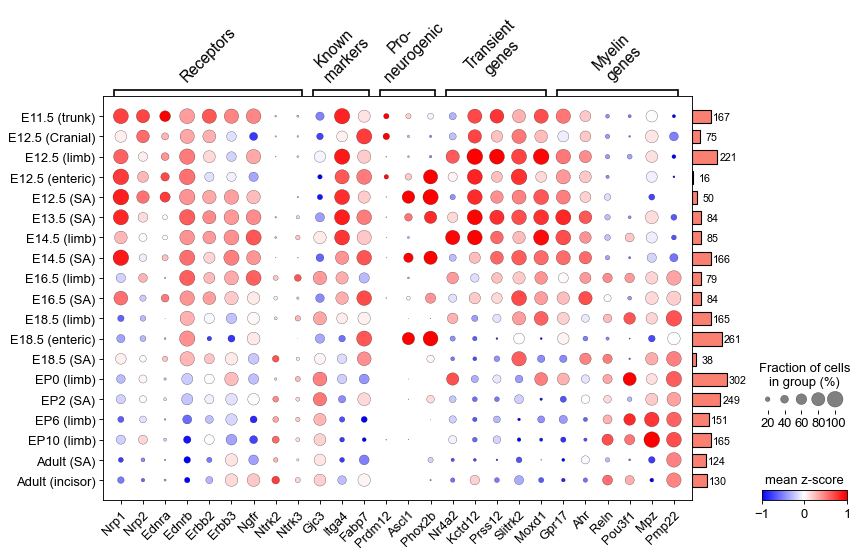

In [32]:
dp=sc.pl.dotplot(adata_glia[rem],var_names=marker_genes_dict,var_group_rotation=45,
              groupby="devloc",layer="scaled",cmap="bwr",vmin=-1,vmax=1,return_fig=True,colorbar_title='mean z-score')

dp.add_totals().style()
dp.cmap="bwr"
plt.setp(dp.get_axes()['mainplot_ax'].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.savefig("figures/Glial_markers_devloc.svg",dpi=600,tight_layout=True)

In [33]:
import palantir 
%matplotlib inline
dm_res = palantir.utils.run_diffusion_maps(pd.read_csv('PCA_genes.csv',index_col=0),knn=50)
data = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
imp_df = palantir.utils.run_magic_imputation(data, dm_res)
adata.layers["magic"]=imp_df.values

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


Determing nearest neighbor graph...


In [34]:
adata_glia.layers["magic"]=adata[adata_glia.obs_names].layers["magic"]

In [36]:
scv.set_figure_params(figsize=(5,5),dpi_save=600)
for g in ["Sox10","Plp1"]:
    scv.pl.umap(adata_glia,color=g,cmap='RdBu_r',layer='magic',
                show=False,add_outline=True,colorbar=False,
               save='_glia_magic_marker_'+g+'.svg')

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


saving figure to file ./figures/scvelo__glia_magic_marker_Sox10.svg
saving figure to file ./figures/scvelo__glia_magic_marker_Plp1.svg


In [35]:
l=adata_glia.obs.leiden.cat.categories[0]
sc.get.rank_genes_groups_df(adata_glia,l).names[:6].values

array(['Hmga2', 'Npm1', 'Pls3', 'Kctd12', 'Phactr1', 'Hbb-y'],
      dtype=object)

In [36]:
de_genes=np.concatenate([sc.get.rank_genes_groups_df(adata_glia,l).names[:6].values for l in adata_glia.obs.leiden.cat.categories])

scv.set_figure_params(figsize=(5,5),dpi_save=600)

for g in de_genes:
    scv.pl.umap(adata_glia,color=g,cmap='RdBu_r',layer='magic',
                show=False,add_outline=True,colorbar=False,
               save='_glia_DE_magic_marker_'+g+'.svg')

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


saving figure to file ./figures/scvelo__glia_DE_magic_marker_Hmga2.svg
saving figure to file ./figures/scvelo__glia_DE_magic_marker_Npm1.svg
saving figure to file ./figures/scvelo__glia_DE_magic_marker_Pls3.svg
saving figure to file ./figures/scvelo__glia_DE_magic_marker_Kctd12.svg
saving figure to file ./figures/scvelo__glia_DE_magic_marker_Phactr1.svg
saving figure to file ./figures/scvelo__glia_DE_magic_marker_Hbb-y.svg
saving figure to file ./figures/scvelo__glia_DE_magic_marker_Grb10.svg
saving figure to file ./figures/scvelo__glia_DE_magic_marker_Marcksl1.svg
saving figure to file ./figures/scvelo__glia_DE_magic_marker_Dpysl3.svg
saving figure to file ./figures/scvelo__glia_DE_magic_marker_Dlx2.svg
saving figure to file ./figures/scvelo__glia_DE_magic_marker_Igf2bp1.svg
saving figure to file ./figures/scvelo__glia_DE_magic_marker_Col2a1.svg
saving figure to file ./figures/scvelo__glia_DE_magic_marker_Itga8.svg
saving figure to file ./figures/scvelo__glia_DE_magic_marker_Col20a1.s

In [37]:
marker_genes_dict['Known_markers'] = marker_genes_dict.pop('Known\nmarkers')

In [38]:
marker_genes_dict['Pro-neurogenic'] = marker_genes_dict.pop('Pro-\nneurogenic')
marker_genes_dict['Transient_genes'] = marker_genes_dict.pop('Transient\ngenes')
marker_genes_dict['Myelin_genes'] = marker_genes_dict.pop('Myelin\ngenes')

In [39]:
scv.set_figure_params(figsize=(5,5),dpi_save=600)

for gr in list(marker_genes_dict.keys()):
    for g in marker_genes_dict[gr]:
        scv.pl.umap(adata_glia,color=g,cmap='RdBu_r',layer='magic',
                    show=False,add_outline=True,colorbar=False,
                   save='_glia_magic_'+gr+'_'+g+'.svg')
        scv.pl.umap(adata_glia,color=g,cmap='RdBu_r',
                    show=False,add_outline=True,colorbar=False,
                   save='_glia_'+gr+'_'+g+'.svg')

saving figure to file ./figures/scvelo__glia_magic_Receptors_Nrp1.svg
saving figure to file ./figures/scvelo__glia_Receptors_Nrp1.svg
saving figure to file ./figures/scvelo__glia_magic_Receptors_Nrp2.svg
saving figure to file ./figures/scvelo__glia_Receptors_Nrp2.svg
saving figure to file ./figures/scvelo__glia_magic_Receptors_Ednra.svg
saving figure to file ./figures/scvelo__glia_Receptors_Ednra.svg
saving figure to file ./figures/scvelo__glia_magic_Receptors_Ednrb.svg
saving figure to file ./figures/scvelo__glia_Receptors_Ednrb.svg
saving figure to file ./figures/scvelo__glia_magic_Receptors_Erbb2.svg
saving figure to file ./figures/scvelo__glia_Receptors_Erbb2.svg
saving figure to file ./figures/scvelo__glia_magic_Receptors_Erbb3.svg
saving figure to file ./figures/scvelo__glia_Receptors_Erbb3.svg
saving figure to file ./figures/scvelo__glia_magic_Receptors_Ngfr.svg
saving figure to file ./figures/scvelo__glia_Receptors_Ngfr.svg
saving figure to file ./figures/scvelo__glia_magic_Rec

In [40]:
markers=["Egr2","Pou3f1","Erbb3","Pdgfra","Pdgfrb","L1cam","Scn7a","Adam11","Adam12","Mpz","Prx","Ncmap","Mag","Pmp22","Reln"]

In [41]:
scv.set_figure_params(figsize=(5,5),dpi_save=600)

for g in markers:
    scv.pl.umap(adata_glia,color=g,cmap='RdBu_r',layer='magic',
                show=False,add_outline=True,colorbar=False,
               save='_glia_magic_marker_'+g+'.svg')

g='Mki67'
scv.pl.umap(adata_glia,color=g,cmap='RdBu_r',layer='magic',
            show=False,add_outline=True,colorbar=False,
           save='_glia_magic_marker_'+g+'.svg')

saving figure to file ./figures/scvelo__glia_magic_marker_Egr2.svg
saving figure to file ./figures/scvelo__glia_magic_marker_Pou3f1.svg
saving figure to file ./figures/scvelo__glia_magic_marker_Erbb3.svg
saving figure to file ./figures/scvelo__glia_magic_marker_Pdgfra.svg
saving figure to file ./figures/scvelo__glia_magic_marker_Pdgfrb.svg
saving figure to file ./figures/scvelo__glia_magic_marker_L1cam.svg
saving figure to file ./figures/scvelo__glia_magic_marker_Scn7a.svg
saving figure to file ./figures/scvelo__glia_magic_marker_Adam11.svg
saving figure to file ./figures/scvelo__glia_magic_marker_Adam12.svg
saving figure to file ./figures/scvelo__glia_magic_marker_Mpz.svg
saving figure to file ./figures/scvelo__glia_magic_marker_Prx.svg
saving figure to file ./figures/scvelo__glia_magic_marker_Ncmap.svg
saving figure to file ./figures/scvelo__glia_magic_marker_Mag.svg
saving figure to file ./figures/scvelo__glia_magic_marker_Pmp22.svg
saving figure to file ./figures/scvelo__glia_magic

<AxesSubplot:title={'center':'Mki67  magic'}>

In [45]:
genes=['Mki67',"Cd34","Dhh"]
for g in genes:
    scv.pl.umap(adata_glia,color=g,cmap='RdBu_r',layer='magic',
                show=False,add_outline=True,colorbar=False,
               save='_glia_magic_marker_'+g+'.svg')

saving figure to file ./figures/scvelo__glia_magic_marker_Mki67.svg
saving figure to file ./figures/scvelo__glia_magic_marker_Cd34.svg
saving figure to file ./figures/scvelo__glia_magic_marker_Dhh.svg


saving figure to file ./figures/scvelo__glia_uninjured_endoneurial_cells_Dcn.png


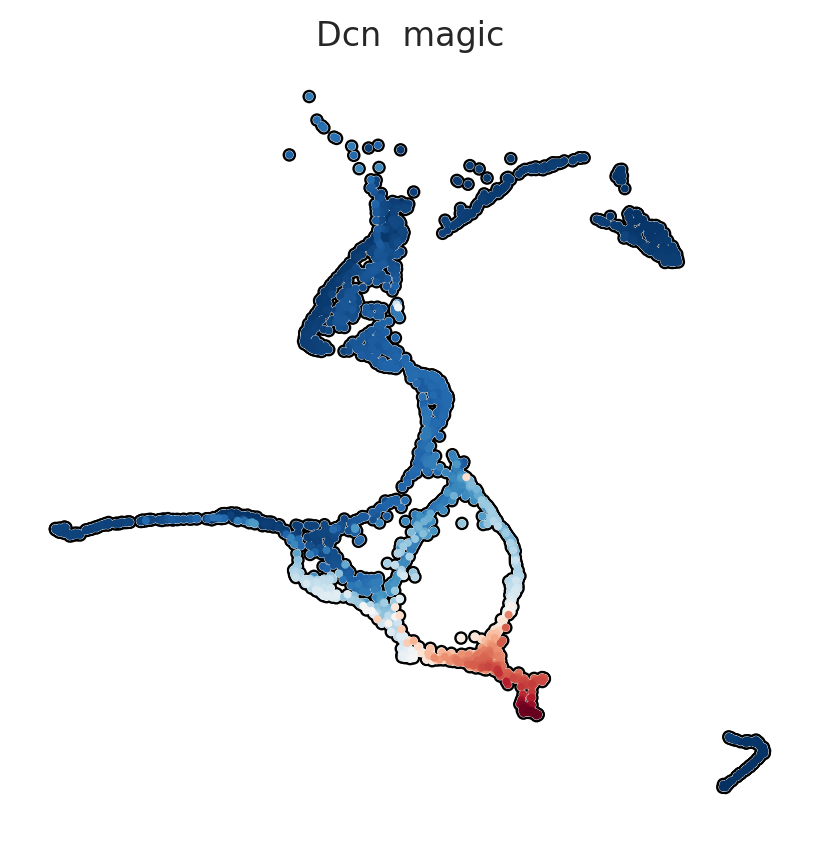

saving figure to file ./figures/scvelo__glia_uninjured_endoneurial_cells_Osr2.png


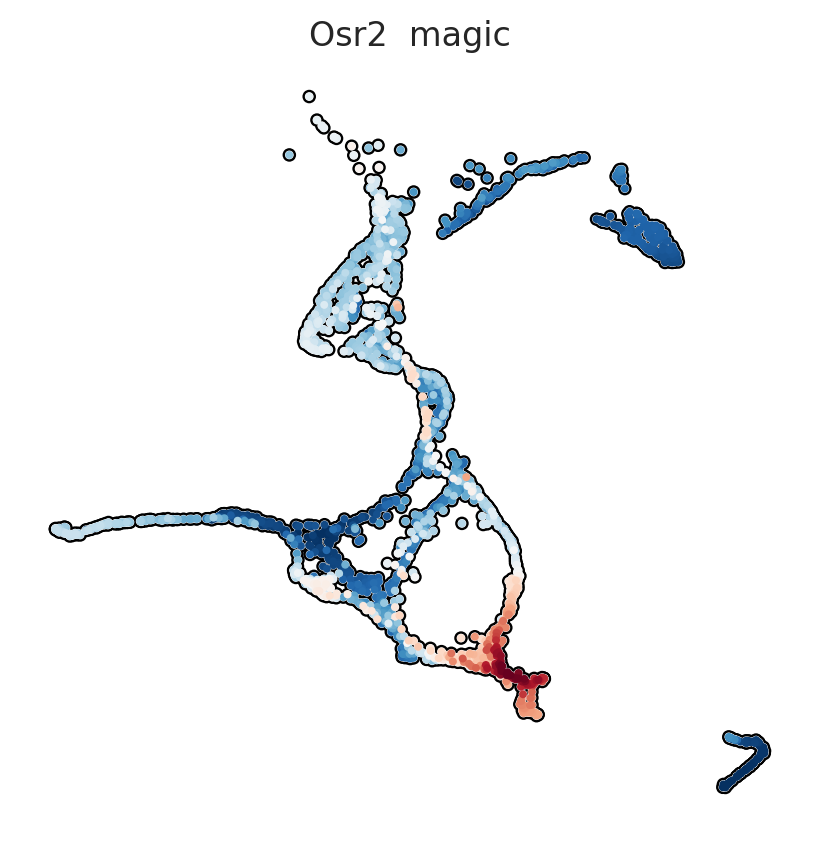

saving figure to file ./figures/scvelo__glia_injured_differentiating_mesenchymes_Dlk1.png


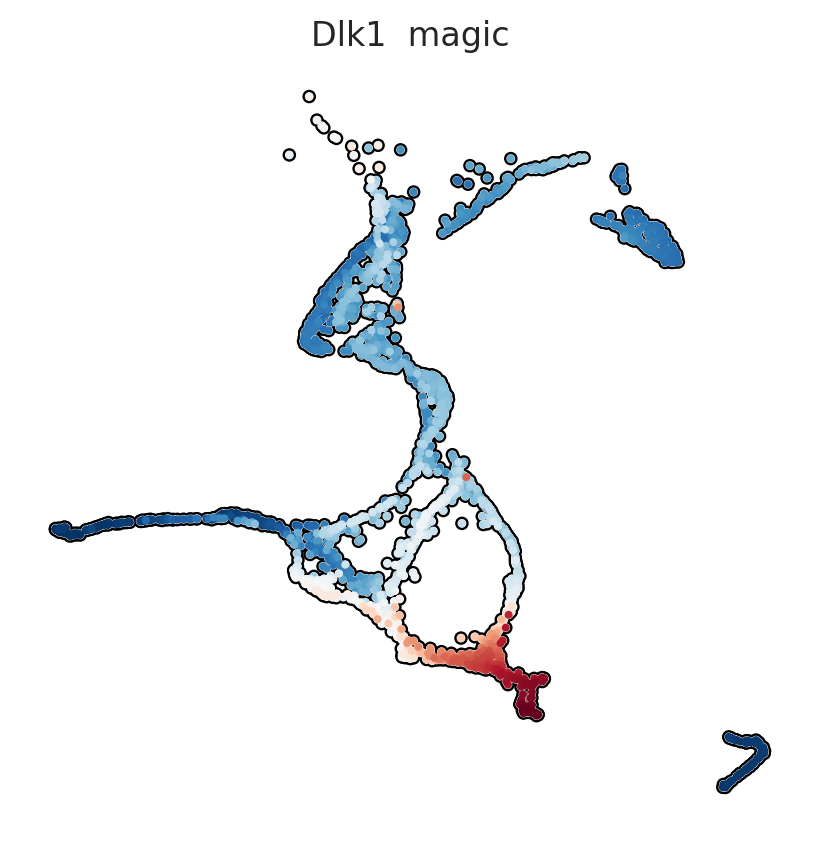

saving figure to file ./figures/scvelo__glia_injured_differentiating_mesenchymes_Tnc.png


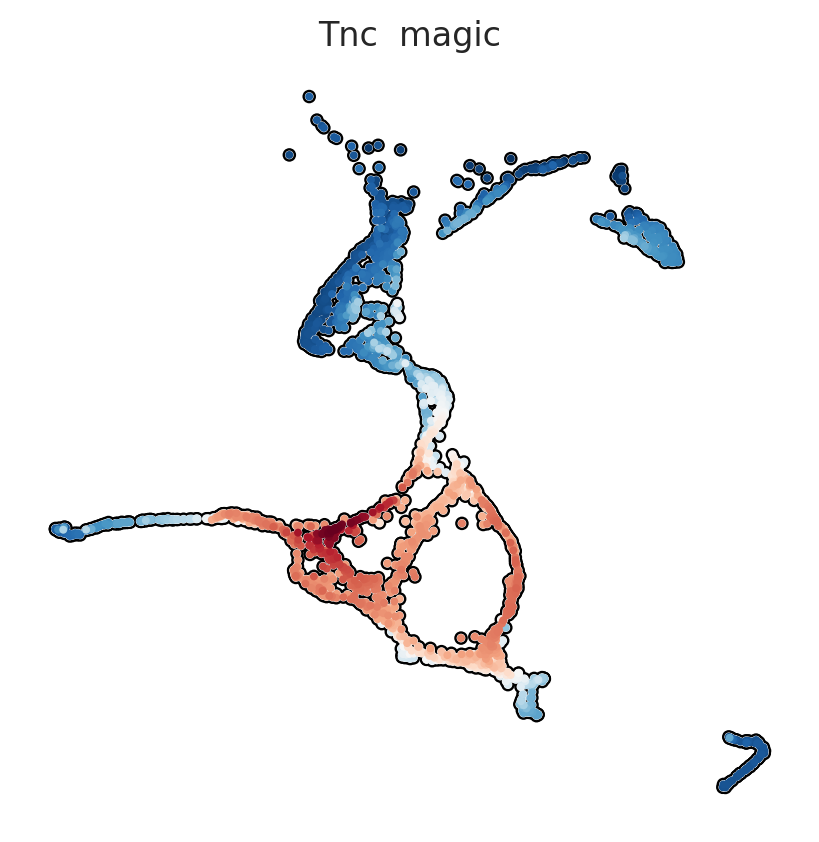

In [42]:
markers={"uninjured_endoneurial_cells":["Dcn","Osr2"],
         "injured_differentiating_mesenchymes":["Dlk1","Tnc"]}

for gr in list(markers.keys()):
    for g in markers[gr]:
        scv.pl.umap(adata_glia,color=g,layer='magic',
                    add_outline=True,colorbar=False,
                    cmap='RdBu_r',save='_glia_'+gr+'_'+g+'.png')

In [43]:
del adata_glia.obs['sel']
del adata_glia.uns['sel_colors']

In [44]:
adata_glia.write_h5ad('adata_glia.h5ad')